In [1]:
from sklearn.model_selection import train_test_split
import concurrent.futures
import cv2
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,  EarlyStopping
from tqdm.keras import TqdmCallback

np.random.seed(42)

#Definations

def load_and_normalize_image(image_path, target_size=(512, 512)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None or img.size == 0:
        print(f"Warning: Could not read image {image_path}")
        return None

    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    normalized_img = img_resized / 255.0
    return normalized_img

def load_and_normalize_images_parallel(dataframe, image_folder, batch_size=1000, n_workers=8, target_size=(512, 512)):
    normalized_images = []
    num_batches = len(dataframe) // batch_size + \
        (1 if len(dataframe) % batch_size != 0 else 0)

    image_paths = [f"{image_folder}/{row['Image Index']}" for _, row in dataframe.iterrows()]

    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = min((i + 1) * batch_size, len(dataframe))
        batch_image_paths = image_paths[batch_start:batch_end]

        with concurrent.futures.ThreadPoolExecutor(max_workers=n_workers) as executor:
            normalized_batch_images = list(executor.map(
            lambda img_path: load_and_normalize_image(img_path, target_size=target_size), batch_image_paths))

        normalized_batch_images = [img for img in normalized_batch_images if img is not None]
        normalized_images.append(normalized_batch_images)

    return np.concatenate(normalized_images, axis=0)


def create_disease_dataset(disease, data):
    disease_data = data[data['Finding Labels'] == disease]
    no_finding_data = data[data['Finding Labels'] == 'No Finding']
    combined_data = pd.concat([disease_data, no_finding_data])
    combined_data['Label'] = combined_data['Finding Labels'].apply(lambda x: 1 if disease in x else 0)
    combined_data= combined_data.drop(columns=['Patient ID', 'Finding Labels', "Follow-up #",
                   'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]'])
    np.random.seed(42)
    combined_data = combined_data.sample(frac=1)
    return combined_data


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv('Data_Entry_2017_v2020.csv')

data1 = data.copy()

data1['Finding Labels'] = data1['Finding Labels'].str.split('|')

exploded_data = data1.explode('Finding Labels').copy()

labels = exploded_data['Finding Labels'].str.split(
    '|').explode().value_counts()

min_count_threshold = 10000

selected_diseases = labels[labels >= min_count_threshold].index


min_images = 1000

undersampled_data = pd.DataFrame(columns=exploded_data.columns)

for disease in selected_diseases:
    disease_data = exploded_data[exploded_data['Finding Labels'].str.contains(
        disease)]

    undersampled_disease_data = disease_data.sample(
        min_images, random_state=42)

    undersampled_data = pd.concat(
        [undersampled_data, undersampled_disease_data])

undersampled_data.reset_index(drop=True, inplace=True)

sampled_labels = undersampled_data['Finding Labels'].str.split(
    '|').explode().value_counts()

print('Loading and undersampling done')


numeric_features = ['Patient Age']
numeric_transformer = Pipeline(steps=[
    ('minmaxscaler', MinMaxScaler())
])

categorical_features = ['Patient Gender', 'View Position']
categorical_transformer = Pipeline(steps=[
    ('onehotencoder', OneHotEncoder(sparse_output=True))
])

preprocessor = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

infiltration_data = create_disease_dataset('Infiltration', undersampled_data)
effusion_data = create_disease_dataset('Effusion', undersampled_data)
atelectasis_data = create_disease_dataset('Atelectasis', undersampled_data)
infiltration_data.reset_index(drop=True, inplace=True)
effusion_data.reset_index(drop=True, inplace=True)
atelectasis_data.reset_index(drop=True, inplace=True)

print('Infiltration:', len(infiltration_data))
print('Effusion:', len(effusion_data))
print('Atelectasis:', len(atelectasis_data))

image_folder = 'C:/Users/Aditya/Desktop/Spring 23/CMSE 890 Applied Machine Learning/Project/images'
X_images_infiltration = load_and_normalize_images_parallel(infiltration_data, image_folder)
y_infiltration = infiltration_data['Label'].values
X_images_effusion = load_and_normalize_images_parallel(effusion_data, image_folder)
y_effusion = effusion_data['Label'].values
X_images_atelectasis = load_and_normalize_images_parallel(atelectasis_data, image_folder)
y_atelectasis = atelectasis_data['Label'].values


Loading and undersampling done
Infiltration: 2000
Effusion: 2000
Atelectasis: 2000


In [2]:
import numpy as np

def apply_pca(X, n_components=0.95):
    X = X.reshape(X.shape[0], -1)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    n_features = X_pca.shape[1]
    new_side_length = int(np.ceil(np.sqrt(n_features)))
    X_pca_padded = np.zeros((X_pca.shape[0], new_side_length**2))
    X_pca_padded[:, :n_features] = X_pca
    X_pca = X_pca_padded.reshape(-1, new_side_length, new_side_length, 1)
    return X_pca

X_images_infiltration_pca = apply_pca(X_images_infiltration)
X_images_effusion_pca = apply_pca(X_images_effusion)
X_images_atelectasis_pca = apply_pca(X_images_atelectasis)

In [3]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(input_shape, n_filters=32, kernel_size=(1, 1), dense_units=64, optimizer='adam'):
    model = Sequential([
        Conv2D(n_filters, kernel_size, activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(X, y, epochs=20, batch_size=32, test_size=0.2, random_state=42,
                             n_filters=32, kernel_size=(1, 1), dense_units=64, optimizer='adam'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    model = create_model(X_train.shape[1:], n_filters=n_filters, kernel_size=kernel_size,
                         dense_units=dense_units, optimizer=optimizer)
    checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    tqdm_callback = TqdmCallback(verbose=1)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[checkpoint,early_stopping, tqdm_callback], verbose=0)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

    return history

def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title + ' - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title + ' - Accuracy')
    plt.legend()
    plt.savefig(f"{title}_model_history.png", dpi=300)
    plt.show()


model = KerasClassifier(model=create_model, input_shape=X_images_infiltration_pca.shape[1:], epochs=20, batch_size=32, verbose=0)

param_grid = {
    'model__n_filters': [16, 32, 64],
    'model__kernel_size': [(1, 1)],
    'model__dense_units': [32, 64, 128],
    'model__optimizer': ['adam']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=0)
grid_result = grid.fit(X_images_infiltration_pca, y_infiltration)

print("Best Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best Score: 0.580500 using {'model__dense_units': 128, 'model__kernel_size': (1, 1), 'model__n_filters': 64, 'model__optimizer': 'adam'}


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Test loss: 0.6578, Test accuracy: 0.5950


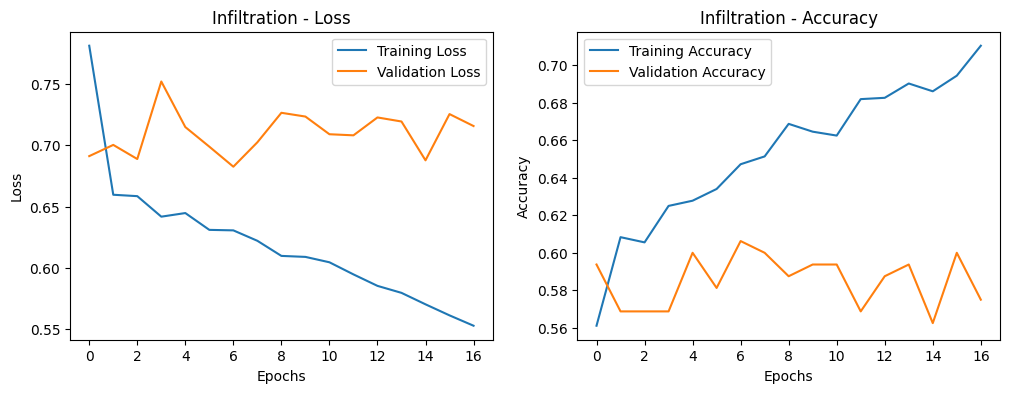

In [4]:
best_params = grid_result.best_params_
infiltration_history = train_and_evaluate_model(
    X_images_infiltration_pca, y_infiltration,
    epochs=75, batch_size=16,
    n_filters=best_params['model__n_filters'],
    kernel_size=best_params['model__kernel_size'],
    dense_units=best_params['model__dense_units'],
    optimizer=best_params['model__optimizer']
)
plot_history(infiltration_history, 'Infiltration')

Best Score: 0.626500 using {'model__dense_units': 64, 'model__kernel_size': (1, 1), 'model__n_filters': 16, 'model__optimizer': 'adam'}


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Test loss: 0.6713, Test accuracy: 0.6100


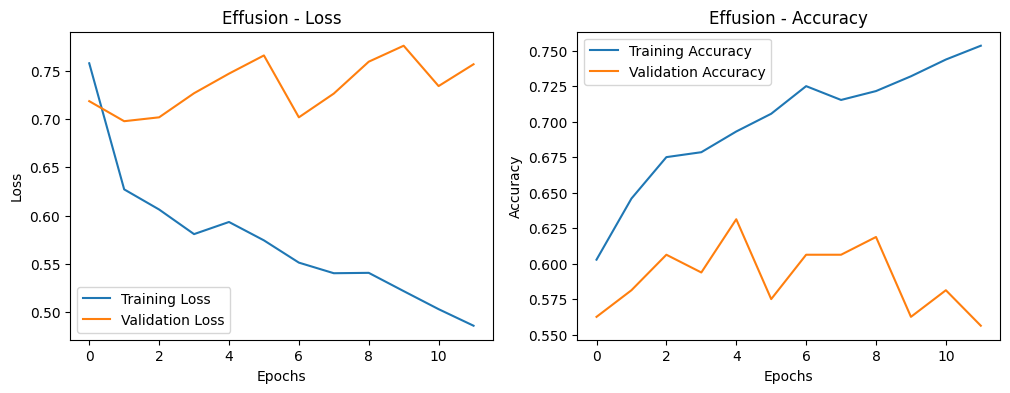

In [6]:

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=0)
grid_result = grid.fit(X_images_effusion_pca, y_effusion)

print("Best Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

best_params = grid_result.best_params_
effusion_history = train_and_evaluate_model(
    X_images_effusion_pca, y_effusion,
    epochs=75, batch_size=32,
    n_filters=best_params['model__n_filters'],
    kernel_size=best_params['model__kernel_size'],
    dense_units=best_params['model__dense_units'],
    optimizer=best_params['model__optimizer']
)
plot_history(effusion_history, 'Effusion')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Test loss: 0.6519, Test accuracy: 0.6900


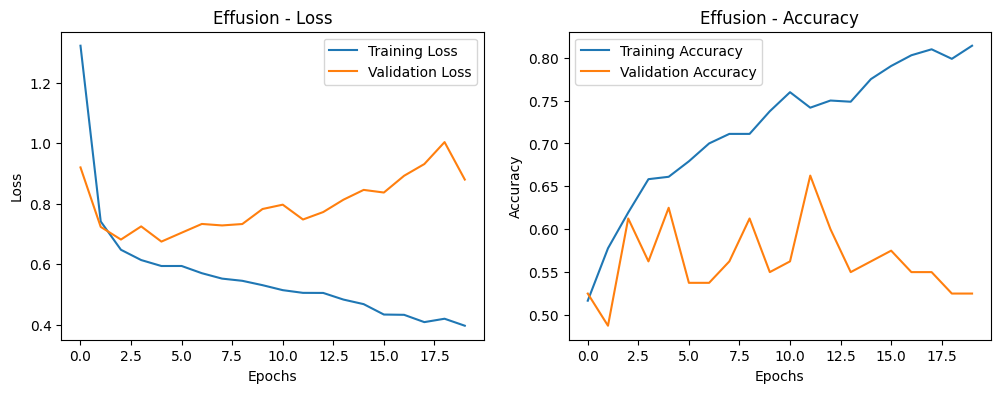

In [11]:
effusion_history = train_and_evaluate_model(X_images_effusion_pca, y_effusion)
plot_history(effusion_history, 'Effusion')



0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Test loss: 0.8633, Test accuracy: 0.5600


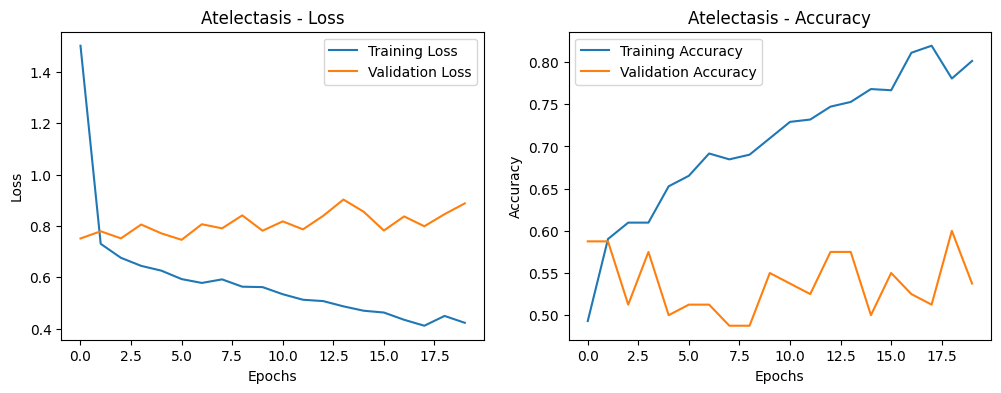

In [12]:
atelectasis_history = train_and_evaluate_model(X_images_atelectasis_pca, y_atelectasis)
plot_history(atelectasis_history, 'Atelectasis')
